In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 1. Load and Visualize the Data
data = pd.read_excel("Gold_price_gbp.xlsx",index_col="Date", parse_dates=True)

In [3]:
prices = data['GBP'].values

In [4]:
# Define the function to create lagged features
def create_lagged_features(series, lag=1):
    X, y = [], []
    for i in range(lag, len(series)):
        X.append(series[i-lag:i])
        y.append(series[i])
    return np.array(X), np.array(y)

In [5]:
# Create lagged features with a lag of 1
lag = 1
X, y = create_lagged_features(prices, lag)

In [6]:
# Define the split index
split_index = int(len(X) * 0.8)

In [7]:
# Split into training and testing sets
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [9]:
# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

In [11]:
# Train the SVR model
svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr.fit(X_train_scaled, y_train_scaled)

# Make predictions
y_pred_scaled = svr.predict(X_test_scaled)

y_pred_scaled = y_pred_scaled.reshape(-1, 1)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

In [12]:
# Flatten the result to make it 1D
y_pred = y_pred.flatten()

In [14]:
# Evaluate the model with various metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
smape = np.mean(np.abs(y_test - y_pred) / ((np.abs(y_test) + np.abs(y_pred)) / 2)) * 100
r2 = r2_score(y_test, y_pred)

# Calculate naive forecast (using previous value as forecast)
y_train_pred_naive = np.roll(y_train, 1)
y_train_pred_naive[0] = y_train[0]  # Set the first value to the first actual value

mae_naive = mean_absolute_error(y_train, y_train_pred_naive)
mase = mae / mae_naive

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Symmetric Mean Absolute Percentage Error (sMAPE):', smape)
print('Mean Absolute Scaled Error (MASE):', mase)
print('R-squared (R2):', r2)


Mean Absolute Error (MAE): 99.54604618960433
Mean Squared Error (MSE): 29626.031072329588
Root Mean Squared Error (RMSE): 172.1221399830062
Mean Absolute Percentage Error (MAPE): 6.653269921013881
Symmetric Mean Absolute Percentage Error (sMAPE): 7.308323906885099
Mean Absolute Scaled Error (MASE): 34.79378411479985
R-squared (R2): 0.6207154267842663


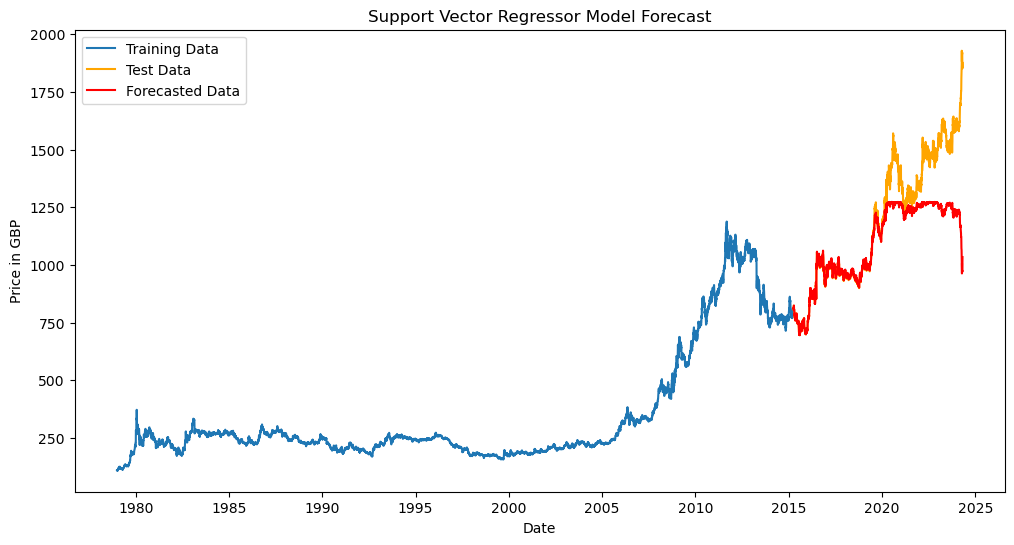

In [20]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data.index[:split_index], y_train, label='Training Data')
plt.plot(data.index[-len(y_test):], y_test, label='Test Data', color='orange')
plt.plot(data.index[-len(y_test):], y_pred, label='Forecasted Data', color='red')
plt.xlabel('Date')
plt.ylabel('Price in GBP')
plt.title('Support Vector Regressor Model Forecast')
plt.legend()
plt.show()